In [1]:
import numpy as np
%matplotlib inline
import random
import matplotlib as matplotlib
from matplotlib import pyplot as plt
import keras
import math
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras import backend as K
import itertools
from sklearn.metrics import confusion_matrix


Using TensorFlow backend.


In [2]:
train_ds = np.load('C:\\Users\\Admin\\Documents\\mini-deep\\modelnet10_train.npz')
val_ds = np.load('C:\\Users\\Admin\\Documents\\mini-deep\\modelnet10_val.npz')
samplesVal = val_ds['samples']
labelsVal = val_ds['labels']
samplesTrain = train_ds['samples']
labelsTrain = train_ds['labels']

In [3]:
#rotating the pics on the x axis
def rotate(pc,deg):
    R = np.array([(1,0,0),
        (0,np.cos(deg),np.sin(deg)),
        (0,-np.sin(deg),np.cos(deg))])   
    pc[:] = pc[:] - [0.5,0.5,0.5]
    pc =  np.dot(pc,R) 
    pc[:] = pc[:] + [0.5,0.5,0.5]
    np.clip(pc,0,1)
    return pc

# def pointcloud2volume(pc, dim=32):
#     vol = np.zeros((dim,dim,dim),dtype=np.int64)    
#     for x in pc:
#         vol[int(x[0]*(dim-1))][int(x[1]*(dim-1))][int(x[2]*(dim-1))] = 1
        
def pointcloud2volume(pc, num_of_angles,angle_idx, dim=32):
    vol = np.zeros((dim, dim, dim))
    angle = (360 / num_of_angles) * angle_idx *  math.pi / 180
    #angle = angle * angle_idx * math.pi / 180
    pcc = np.copy(pc)
    pcc = rotate(pcc, angle)
    pcc[:] *= (dim-1)
    pcc = pcc.astype(int)
    pcc = np.clip(pcc,0,31)
    vol[pcc[:,0], pcc[:,1], pcc[:,2]] = 1.0
#    np.clip(pcc,0,1)
#     for x in pcc:
#          vol[(x[0])][(x[1])][(x[2])] = 1
    return vol

#point cloud to volume
def pointcloud2volumeAngled(pc, num_of_angles,angle_idx, dim=32):
    vol = np.zeros((dim, dim, dim))
    angle = (360 / num_of_angles) * (np.pi / 180) * angle_idx   
    pcc = np.copy(pc)
    pcc = rotate(pcc, angle)
    pcc[:] = pcc[:]*(dim-1)
    pcc = pcc.astype(int)
    pcc = np.clip(pcc,0,31)
    vol[pcc[:,0], pcc[:,1], pcc[:,2]] = 1.0
    return vol


#volume to depthmap
def vol2depthmap(v, bg_val=40.):
    k=v.argmax(2)
    for x in range(32):
            for y in range(32):
                if k[x,y]==0:
                    k[x,y]=40
             
    return k

#plotting depth map
def plot_depth_map(img_num, num_rot):
    import numpy as np
    volmap = []
    depthmap = []
    angled_vector= []
    for i in range(num_rot):
        volmap = pointcloud2volumeAngled(samplesVal[img_num],num_rot,i)
        depthmap = vol2depthmap(volmap)
        angled_vector.append(depthmap)
    plt.imshow(np.vstack(angled_vector), cmap='jet')
    plt.colorbar()
    plt.show()

#creates the Vectored dataset with every angle for each image

def CreateAngledDataset(samples, num_of_angles):
    datalength = len(samples)    
    MVDS = np.zeros((datalength,num_of_angles,32,32)) #multiview Dataset
    SMVDS = np.zeros((num_of_angles,32,32))  #single multiview Dataset
    for i in range (datalength):
        for angle in range(num_of_angles):
            pic = pointcloud2volumeAngled(samples[i],num_of_angles,angle)
            picdepth = vol2depthmap(pic)
            SMVDS[angle] = picdepth
        MVDS[i] = SMVDS
    return MVDS


In [4]:
# Split layer class
# the class of the split layer to split them
# and to build the relevant model

import keras
import tensorflow as tf

class SplitLayer(keras.layers.Layer):
    """
    Layer expects a tensor (multi-dimensonal array) of shape (samples, views, ...)
    and returns a list of #views elements, each of shape (samples, ...)
    """
    
    def __init__(self, num_splits, **kwargs):
        self.num_splits = num_splits
        super(SplitLayer, self).__init__(**kwargs)
    
    def call(self, x):
        return [x[:, i] for i in range(self.num_splits)]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0],) + input_shape[2:]]*self.num_splits
    
    
def make_cnn():    
    num_channels = 32
    cnn = keras.models.Sequential()
    cnn.add(keras.layers.Conv2D(num_channels, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(32, 32, 1)))
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn.add(keras.layers.Conv2D(num_channels*2, (3, 3), activation='relu'))
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.25))
    cnn.add(keras.layers.Flatten())
    cnn.add(keras.layers.Dense(128, activation='relu'))
    
   # cnn.add(Dropout(0.5))
    
    
    return cnn

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

   # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def MVCNN(epochs, num_of_angles):


    num_classes = 10

    input = keras.layers.Input((num_of_angles, 32, 32, 1))
    views = SplitLayer(num_of_angles)(input)
    proc_views = []
    cnn=make_cnn() # create the model
    for v in views:
        proc_views.append(cnn(v))

    single_vector = keras.layers.Maximum()(proc_views)
    x = Dropout(0.23)(single_vector)
    x = keras.layers.Dense(128)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = keras.models.Model(input, x)

    
    #Data assignment
    samplesVal = val_ds['samples']
    samplesTrain = train_ds['samples']

    labelsVal = val_ds['labels']
    labelsTrain = train_ds['labels']


    samplesData = CreateAngledDataset(samplesVal, num_of_angles)
    samplesDataTrain = CreateAngledDataset(samplesTrain, num_of_angles)
    print("samples shape: %s, labels shape: %s" % (samplesVal.shape, labelsVal.shape))

    (x_train, y_train) = (samplesDataTrain, labelsTrain)
    (x_test, y_test) = (samplesData, labelsVal)
    batch_size = 128
    num_classes = 10

    # input image dimensions
    img_rows, img_cols = 32, 32
    # the data, shuffled and split between train and test sets


    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0],num_of_angles, 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], num_of_angles, 1, img_rows, img_cols)

    else:
        x_train = x_train.reshape(x_train.shape[0], num_of_angles, img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], num_of_angles, img_rows, img_cols, 1)


    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    x_train /= 255
    x_test /= 255

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

    model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)
    predictions = model.predict(x_test,batch_size=10, verbose=0)
    predictions = np.argmax(predictions,axis=1)
    print('Test loss:', score[0])
    
    print('Test accuracy:', score[1], '\n')
    
    cm = confusion_matrix(labelsVal,predictions)
    cm_plot_labels = ['bathtub' , 'bed' ,'chair' ,'desk' ,'dresser' ,'monitor' ,'night_stand' ,'sofa' ,'table' ,'toilet' ]
    plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')

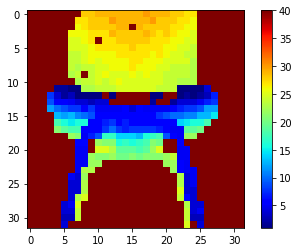

In [65]:
plot_depth_map(19,1)

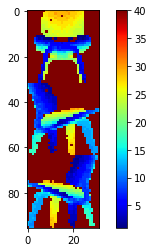

In [66]:
plot_depth_map(19,3)

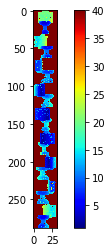

In [67]:
plot_depth_map(4,9)

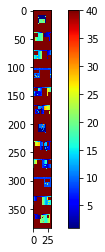

In [68]:
plot_depth_map(49,12)

samples shape: (908, 4000, 3), labels shape: (908,)
x_train shape: (3991, 3, 32, 32, 1)
3991 train samples
908 test samples
Train on 3991 samples, validate on 908 samples
Epoch 1/12
3991/3991 [==============================] - 25s - loss: 2.1683 - acc: 0.2137 - val_loss: 2.3784 - val_acc: 0.1101
Epoch 2/12
3991/3991 [==============================] - 22s - loss: 1.9244 - acc: 0.3132 - val_loss: 1.7801 - val_acc: 0.3348
Epoch 3/12
3991/3991 [==============================] - 20s - loss: 1.1053 - acc: 0.6477 - val_loss: 1.1070 - val_acc: 0.6101
Epoch 4/12
3991/3991 [==============================] - 20s - loss: 0.7995 - acc: 0.7382 - val_loss: 0.8212 - val_acc: 0.7093
Epoch 5/12
3991/3991 [==============================] - 20s - loss: 0.6642 - acc: 0.7868 - val_loss: 0.9372 - val_acc: 0.6949
Epoch 6/12
3991/3991 [==============================] - 20s - loss: 0.6211 - acc: 0.7938 - val_loss: 0.8453 - val_acc: 0.7181
Epoch 7/12
3991/3991 [==============================] - 20s - loss: 0.577

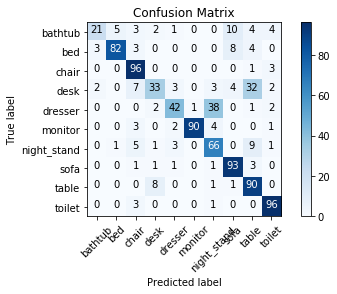

In [69]:
MVCNN(12,3)

samples shape: (908, 4000, 3), labels shape: (908,)
x_train shape: (3991, 6, 32, 32, 1)
3991 train samples
908 test samples
Train on 3991 samples, validate on 908 samples
Epoch 1/12
3991/3991 [==============================] - 49s - loss: 2.1423 - acc: 0.2278 - val_loss: 2.2514 - val_acc: 0.1101
Epoch 2/12
3991/3991 [==============================] - 46s - loss: 1.6681 - acc: 0.4345 - val_loss: 1.5557 - val_acc: 0.4471
Epoch 3/12
3991/3991 [==============================] - 42s - loss: 0.9844 - acc: 0.6763 - val_loss: 1.1052 - val_acc: 0.5969
Epoch 4/12
3991/3991 [==============================] - 42s - loss: 0.8112 - acc: 0.7331 - val_loss: 0.9709 - val_acc: 0.6509
Epoch 5/12
3991/3991 [==============================] - 42s - loss: 0.6698 - acc: 0.7805 - val_loss: 0.8526 - val_acc: 0.6531
Epoch 6/12
3991/3991 [==============================] - 42s - loss: 0.6229 - acc: 0.8016 - val_loss: 0.7952 - val_acc: 0.7280
Epoch 7/12
3991/3991 [==============================] - 42s - loss: 0.570

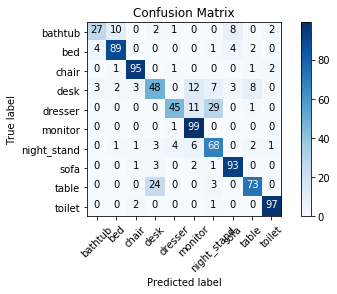

In [ ]:
MVCNN(12,6)

samples shape: (908, 4000, 3), labels shape: (908,)
x_train shape: (3991, 12, 32, 32, 1)
3991 train samples
908 test samples
Train on 3991 samples, validate on 908 samples
Epoch 1/12
3991/3991 [==============================] - 81s - loss: 2.1338 - acc: 0.2340 - val_loss: 2.2444 - val_acc: 0.1916
Epoch 2/12
3991/3991 [==============================] - 79s - loss: 1.5597 - acc: 0.4706 - val_loss: 1.2172 - val_acc: 0.5969
Epoch 3/12
3991/3991 [==============================] - 79s - loss: 0.9375 - acc: 0.6753 - val_loss: 1.4226 - val_acc: 0.5033
Epoch 4/12
3991/3991 [==============================] - 80s - loss: 0.7935 - acc: 0.7359 - val_loss: 1.0300 - val_acc: 0.6333
Epoch 5/12
3991/3991 [==============================] - 79s - loss: 0.6832 - acc: 0.7697 - val_loss: 0.9760 - val_acc: 0.6399
Epoch 6/12
3991/3991 [==============================] - 79s - loss: 0.5994 - acc: 0.8048 - val_loss: 0.7062 - val_acc: 0.7621
Epoch 7/12
3991/3991 [==============================] - 78s - loss: 0.55

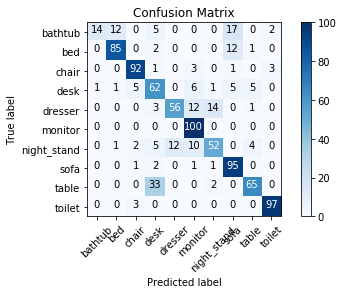

In [7]:
MVCNN(12,12)

samples shape: (908, 4000, 3), labels shape: (908,)
x_train shape: (3991, 12, 32, 32, 1)
3991 train samples
908 test samples
Train on 3991 samples, validate on 908 samples
Epoch 1/48
3991/3991 [==============================] - 89s - loss: 2.1285 - acc: 0.2255 - val_loss: 2.2006 - val_acc: 0.1101
Epoch 2/48
3991/3991 [==============================] - 102s - loss: 1.5231 - acc: 0.4954 - val_loss: 1.5153 - val_acc: 0.3954
Epoch 3/48
3991/3991 [==============================] - 94s - loss: 0.9425 - acc: 0.6810 - val_loss: 1.0612 - val_acc: 0.6244
Epoch 4/48
3991/3991 [==============================] - 125s - loss: 0.7601 - acc: 0.7467 - val_loss: 1.1302 - val_acc: 0.6035
Epoch 5/48
3991/3991 [==============================] - 101s - loss: 0.6786 - acc: 0.7770 - val_loss: 1.0212 - val_acc: 0.6498
Epoch 6/48
3991/3991 [==============================] - 110s - loss: 0.5981 - acc: 0.8026 - val_loss: 0.8563 - val_acc: 0.7059
Epoch 7/48
3991/3991 [==============================] - 84s - loss: 

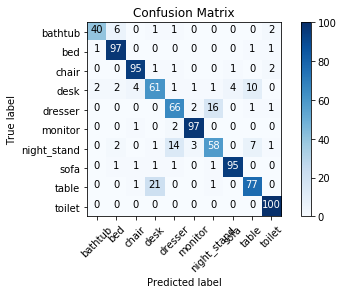

In [8]:
MVCNN(48,12)